# 1. Data processing

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)          # None means unlimited
pd.set_option('future.no_silent_downcasting', True)


posts_df = pd.read_csv("posts.csv", low_memory=False)
df = posts_df
#df.head()

In [2]:
df.dtypes

_id                     object
reactions.SAD            int64
reactions.WOW            int64
reactions.LOVE           int64
reactions.HAHA           int64
reactions.ANGRY          int64
reactions.LIKE           int64
reactions.THANKFUL     float64
user_id                  int64
link                    object
date                    object
message                 object
emotion[0]             float64
emotion[1]             float64
emotion[2]             float64
emotion[3]             float64
emotion[4]             float64
emotion[5]             float64
emotion[6]             float64
emotion[7]              object
comments_emotion[0]    float64
comments_emotion[1]    float64
comments_emotion[2]    float64
comments_emotion[3]    float64
comments_emotion[4]    float64
comments_emotion[5]    float64
comments_emotion[6]    float64
comments_emotion[7]    float64
sentiment              float64
comments_sentiment     float64
off_topic                 bool
dtype: object

In [3]:
#df.describe()

In [4]:
#print(df.isna().sum())  # Check for missing values in the DataFrame

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch


posts = df['message'].astype(str).values

metadata_path = 'metadata.tsv'
# simple tokenization based on the words in your metadata.tsv
# word_index = {}
# with open(metadata_path, 'r', encoding='utf-8') as f:
#     for i, line in enumerate(f):
#         word = line.strip()
#         word_index[word] = i + 1  # Typically, 0 is reserved for padding

# Tokenize your texts into sequences of integers
# sequences = [[word_index.get(w, 0) for w in post.split()] for post in posts]
# max_length = 100  # Determine a suitable maximum sequence length
# data = pad_sequences(sequences, maxlen=max_length)
data = posts #df['message']
data_list = data.tolist()
data = data_list

2024-05-07 08:57:48.470907: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 08:57:48.505676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 08:57:49.273850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Labels:

In [6]:
label_columns = ['emotion[0]', 'emotion[1]', 'emotion[2]', 'emotion[3]', 'emotion[4]', 'emotion[5]', 'emotion[6]', 'emotion[7]']
labels = df[label_columns]

for col in label_columns:   
    labels.loc[:, col] = pd.to_numeric(labels[col], errors='coerce') #labels[col]

# filling NAN with median
labels_medians = labels.median()
labels_clean = labels.fillna(labels_medians).infer_objects(copy=False)
labels = labels_clean 
# print('\nlabels:\n', labels)

# # softmax over each row
# def softmax(x):
#     e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Ensure max is subtracted properly
#     sum_e_x = e_x.sum(axis=1, keepdims=True)  # Sum should also be proper
#     return e_x / sum_e_x  # Broadcast the division correctly

# softmax_labels = softmax(labels.values)
softmax_data = F.softmax(torch.tensor(labels.values), dim=1)
#print(softmax_data)
softmax_df = pd.DataFrame(softmax_data.numpy(), columns=label_columns)
#print(softmax_df.values)

labels = softmax_df

In [7]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# string_series = pd.Series(data_list)

# word_counts = string_series.apply(lambda s: len(s.split()))

# average_word_count = word_counts.mean()
# quartiles = word_counts.quantile([0.25, 0.5, 0.75])

# print(f"Average Number of Words: {average_word_count}")
# print(f"Quartiles:\n{quartiles}")

# # Create and display a boxplot
# sns.boxplot(y=word_counts)
# plt.title('Boxplot of Word Counts')
# plt.ylabel('Number of Words')
# plt.show()

In [8]:
# # Checking posts with word count greater than 512
# i = 0
# n = len(data_list)
# for s in data_list:
#     if len(s.split()) > 512:
#         i+=1
# print(i)
# print(n-i)
# print(n)

Client dataset setup: 

In [9]:
# ###############################################
# data = data[:20000]
# labels = labels[:20000]
# ################################################

num_clients = 10

clients = []
for i in range(num_clients):
    clients.append({'client_no': i,
                    'data' : data[i*(int(len(data)/(num_clients+1))) : (i+1)*(int(len(data)/(num_clients+1)))],
                    'labels' : labels[i*(int(len(data)/(num_clients+1))) : (i+1)*(int(len(data)/(num_clients+1)))],
                    'loss_history' : []})
    # print(len(clients[i]['labels']))

# 2. Primary Model (BERT)

In [17]:
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import logging
from torch.optim import AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import numpy as np
logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #"cuda" if torch.cuda.is_available() else "cpu"

def encode_texts(text_list, max_length=512):
    return tokenizer(text_list, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')


######################################################################################################
num_rounds = 2 #2 #20
init_weights = None
init_bias = None

glob_weights = None
glob_bias = None
lambda_g = 1e-10

# num_clients = 2

round_history = []
for n_round in range(num_rounds):
    round_test_losses_per_client = []
    print("---------------------------------------------------------")
    print(f'Round - {n_round+1}\n')
    
    for i in range(num_clients): #num_clients
        c_data = clients[i]['data']
        c_labels = clients[i]['labels']
        
        x_train, x_val, y_train, y_val = train_test_split(c_data, c_labels, test_size=0.2, random_state=123)

        ###################################################
        # pre-trained model tokenizer (vocabulary)
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # pre-trained model (weights)
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=8)

        # Freeze the bert model parameters (except classifier layer)
        for name, param in model.named_parameters():
            if 'classifier' in name:
                param.requires_grad = True # only classifier update
            else:
                param.requires_grad = False

        if(n_round == 0):
            if(init_weights != None):
                model.classifier.weight = torch.nn.Parameter( init_weights.clone().detach(), requires_grad=True )
                model.classifier.bias   = torch.nn.Parameter( init_bias.clone().detach(), requires_grad=True )
            else:
                init_weights = model.classifier.weight.clone().detach()
                init_bias    = model.classifier.bias.clone().detach()
        else:
            model.classifier.weight = torch.nn.Parameter( new_c_weight.clone().detach(), requires_grad=True ).to(device)
            model.classifier.bias   = torch.nn.Parameter( new_c_bias.clone().detach(), requires_grad=True ).to(device)
        
        glob_weights = model.classifier.weight
        glob_bias = model.classifier.bias

        ###################################################

        ######################################################################################################
        #torch.cuda.empty_cache()

        model.to(device)
        model.eval()
        
        ######################################################################################################

        # checking per round loss before training
        p_loss = [] #0
        n_t_batch = 0

        test_encodings = encode_texts(x_val)
        test_labels = torch.tensor(y_val.values).clone().detach().to(device)
        test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels) #, test_labels
        test_loader = DataLoader(test_dataset, batch_size=16)

        del test_dataset
        del test_labels
        del test_encodings

        for batch in test_loader:
            test_input_ids, test_attention_mask, test_b_labels = batch
            test_inputs = {'input_ids': test_input_ids.to(device), 
                           'attention_mask': test_attention_mask.to(device)}#, 
                           #'labels': test_b_labels.to(device)}

            del test_input_ids
            del test_attention_mask
            del batch

            test_outputs = model(**test_inputs)  
            b_loss = F.binary_cross_entropy_with_logits(test_outputs.logits.clone().detach(), test_b_labels)  # F.softmax( , dim=-1)#torch.tensor()
                                                        #test_labels[n_t_batch*16: (n_t_batch+1)*16]
            n_t_batch+=1
            p_loss.append(b_loss)
            del test_inputs
            del test_outputs
            del test_b_labels

        p_loss = [p_loss[i].item() for i in range(len(p_loss))]
        round_test_losses_per_client.append(np.array(p_loss).mean())
        print(f'\nclient:\t{i+1}\tPre-optimization Loss:\t{np.array(p_loss).mean()}')

        # del test_labels
        del test_loader
        # del test_dataset
        del p_loss

        ########################################################################
        
        # set model to training mode
        model.train()

        optimizer = AdamW(model.parameters(), lr=5e-5) # 1e-6

        # Assume x_train and y_train are your dataset's features and labels respectively
        train_encodings = encode_texts(x_train)

        # Assuming train_encodings includes 'input_ids' and 'attention_mask',
        # and train_labels is correctly formatted
        train_labels = torch.tensor(y_train.values).clone().detach()
                        #torch.tensor(torch.tensor(y_train.values)) #.clone().detach()#torch.tensor()
        train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


        # training loop
        round_losses = []
        for epoch in range(1):
            loss_list = []
            for batch in train_loader:
                # Ensure batch is unpacked correctly
                input_ids, attention_mask, labels = batch
                inputs = {'input_ids': input_ids.to(device), 
                          'attention_mask': attention_mask.to(device), 
                          'labels': labels.to(device)}
                model.train()
                outputs = model(**inputs)
                loss = outputs.loss #[0]

                loss_list.append(loss)
                #print(F.cross_entropy(labels, outputs.logitd))
                print(f"\rTraining - Current Loss: {loss}", end="")

                # b_loss = F.binary_cross_entropy_with_logits(outputs.logits.clone().detach().to(device), labels.to(device))
                # print('\n',b_loss)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
            loss_list = [loss_list[i].item() for i in range(len(loss_list))]
            #print(np.array(loss_list).mean())
            round_losses.append(np.array(loss_list).mean())
        clients[i]['loss_history'].append(round_losses[-1]) # only the last loss from epochs (round loss)
        clients[i]['c_weights'] = model.classifier.weight
        clients[i]['c_bias'] = model.classifier.bias

        print(f'\rclient: {i+1}\tTraining loss:\t', round_losses[-1], end="")

        ########################################################################
    ### SERVER UPDATE - SIM ###
    new_c_weight = 0
    new_c_bias = 0
    for i in range(num_clients):
        # c_data = clients[i]['data']
        # c_labels = clients[i]['labels']
        # clients[i]['loss_history'].append(round_losses[-1]) # only the last loss from epochs
        # clients[i]['c_weights'] = model.classifier.weight
        new_c_weight += clients[i]['c_weights'] + lambda_g * (glob_weights - clients[i]['c_weights'])**2 # regularized update
        new_c_bias   += clients[i]['c_bias']    + lambda_g * (glob_bias - clients[i]['c_bias'])**2
    new_c_weight = new_c_weight/num_clients
    new_c_bias = new_c_bias/num_clients
    #print(new_c_weight/3)#, clients[i]['c_weights'])

    del model
    round_history.append(round_test_losses_per_client)
    print("\n---------------------------------------------------------")



---------------------------------------------------------
Round - 1


client:	1	Pre-optimization Loss:	0.6433142085203479
client: 1	Training loss:	 0.40202592251621816
client:	2	Pre-optimization Loss:	0.6426356814703988
client: 2	Training loss:	 0.39925197011671015
client:	3	Pre-optimization Loss:	0.6403348493719561
client: 3	Training loss:	 0.3995302639622413
client:	4	Pre-optimization Loss:	0.6417833046350571
client: 4	Training loss:	 0.4053150933737361
client:	5	Pre-optimization Loss:	0.6388387856767642
client: 5	Training loss:	 0.39951362830984677
client:	6	Pre-optimization Loss:	0.6388993353303435
client: 6	Training loss:	 0.3973718363009753
client:	7	Pre-optimization Loss:	0.6402145683385888
client: 7	Training loss:	 0.40181972087124074
client:	8	Pre-optimization Loss:	0.6462667924881412
client: 8	Training loss:	 0.40275258743261083
client:	9	Pre-optimization Loss:	0.6482264387709674
client: 9	Training loss:	 0.4039394509958988
client:	10	Pre-optimization Loss:	0.6477125461961406

In [11]:
for i in range(num_clients):
        # c_data = clients[i]['data']
        print(clients[i]['loss_history'])

[0.7455859143799037, 0.7005818573567741, 0.6588079516944534, 0.6197723217807124, 0.5852436694024911, 0.5534695706644057, 0.5254586071722228, 0.5005612897430515, 0.47853363303233576, 0.45920464600581384, 0.44238158354889795, 0.42849877772843226, 0.416168723346357, 0.40542614590578663, 0.3976212539196473, 0.39154107792682846, 0.3846872867101002, 0.37999464298620445, 0.3771681956159486, 0.3741103307857605]
[0.7470215027641557, 0.7006580729440973, 0.6580950590564415, 0.619897937682773, 0.584815807209328, 0.5533243563271771, 0.5250616265948943, 0.5005903117630955, 0.4777186256530697, 0.4591219713542934, 0.44179818825428174, 0.4273584817262527, 0.415131139334582, 0.40442839820057225, 0.3955355701653643, 0.3886464155834699, 0.38307652391160674, 0.37823330086582463, 0.3744843300196368, 0.3714656776486915]
[0.7481641163424944, 0.7014662202343689, 0.6586162560577427, 0.6197399545839757, 0.584383121260103, 0.5523797494447585, 0.5244352795401952, 0.4991420691162033, 0.47679812359955304, 0.45748905

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,5))

# for i in range(num_clients):
#         plt.plot(clients[i]['loss_history'])
# plt.xlabel("Rounds")
# plt.ylabel("Loss")
# plt.title("Loss over rounds")
# plt.show()

In [13]:
# print(F.softmax(torch.tensor(outputs.logits.cpu().detach().numpy()), dim=1))#(np.array(outputs.logits.cpu().detach().numpy()))
# # print(outputs.loss)
# print(inputs['labels'])

## Saving history:

In [18]:
import pickle

# Saving
with open('client_history.pickle', 'wb') as handle:
    pickle.dump(clients, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
import pickle

# Loading
with open('client_history.pickle', 'rb') as handle:
    clients = pickle.load(handle)

# print(clients == client_h)

In [ ]:
with open('round_history.pickle', 'wb') as handle:
    pickle.dump(round_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('round_history.pickle', 'rb') as handle:
    round_history_h = pickle.load(handle)
# print(round_history == round_history_h)

Text(0.5, 1.0, 'Loss over rounds (clients 1-10)')

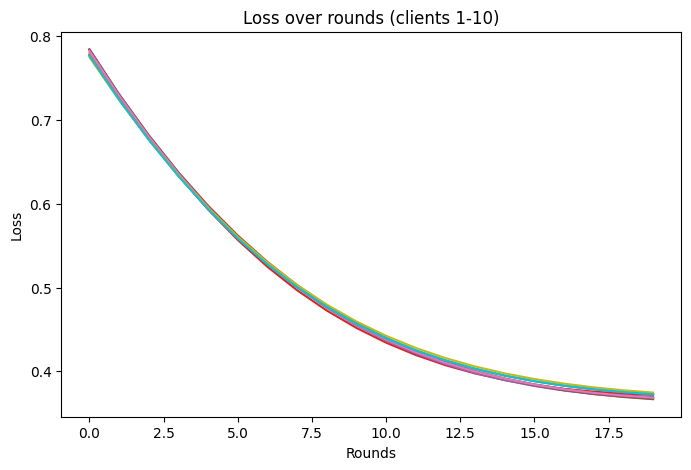

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for i in range(num_clients):   
    plt.plot([x[i] for x in round_history_h])
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.title("Loss over rounds (clients 1-10)")

# Final testing:

In [3]:
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import logging
from torch.optim import AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #"cuda" if torch.cuda.is_available() else "cpu"

def encode_texts(text_list, max_length=512):
    return tokenizer(text_list, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=8)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_clients = 10
###################################################
# pre-trained model tokenizer (vocabulary)

new_c_weight = 0
new_c_bias = 0
for i in range(num_clients):
       new_c_weight += clients[i]['c_weights']
       new_c_bias   += clients[i]['c_bias']
new_c_weight = new_c_weight/num_clients
new_c_bias = new_c_bias/num_clients


model.classifier.weight = torch.nn.Parameter( new_c_weight.clone().detach().to(device), requires_grad=True )
model.classifier.bias   = torch.nn.Parameter( new_c_bias.clone().detach().to(device), requires_grad=True )
model.to(device)
model.eval()



for i in range(num_clients): #num_clients
       print(f"client: {i+1}\n")
       c_data = clients[i]['data']
       c_labels = clients[i]['labels']
       
       x_train, x_val, y_train, y_val = train_test_split(c_data, c_labels, test_size=0.2, random_state=123)

       # Assume x_train and y_train are your dataset's features and labels respectively
       test_encodings = encode_texts(x_train)

       # Assuming train_encodings includes 'input_ids' and 'attention_mask',
       # and train_labels is correctly formatted
       test_labels = torch.tensor(y_train.values).clone().detach()
                     #torch.tensor(torch.tensor(y_train.values)) #.clone().detach()#torch.tensor()
       test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)
       test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
       
       del test_labels, test_dataset, test_encodings

       # training loop
       round_losses = []
       loss_list = []
       for batch in test_loader:
              input_ids, attention_mask, labels = batch
              inputs = {'input_ids': input_ids.to(device), 
                     'attention_mask': attention_mask.to(device), 
                     'labels': labels.to(device)}
              # model.train()
              outputs = model(**inputs)
              loss = outputs.loss #[0]

              loss_list.append(loss)
              #print(F.cross_entropy(labels, outputs.logitd))
              print(f"\rTest - Current Loss: {loss}", end="")
              
              del input_ids, attention_mask, labels
              break
       loss_list = [loss_list[i].item() for i in range(len(loss_list))]
       #print(np.array(loss_list).mean())
       round_losses.append(np.array(loss_list).mean())
       print("\n\n")

client: 1

Test - Current Loss: 0.3558692397220059


client: 2

Test - Current Loss: 0.36741629932631203


client: 3

Test - Current Loss: 0.3610631827752113


client: 4

Test - Current Loss: 0.3708866713690918


client: 5

Test - Current Loss: 0.35977029139375466


client: 6

Test - Current Loss: 0.34764334151713017


client: 7

Test - Current Loss: 0.36275529049193833


client: 8

Test - Current Loss: 0.36855344847835636


client: 9

Test - Current Loss: 0.37045217693080307


client: 10

Test - Current Loss: 0.36639318063308246




# Saving the model:

In [4]:
model.save_pretrained('./fed_finetune_v1')
tokenizer.save_pretrained('./fed_finetune_v1')

('./fed_finetune_v1/tokenizer_config.json',
 './fed_finetune_v1/special_tokens_map.json',
 './fed_finetune_v1/vocab.txt',
 './fed_finetune_v1/added_tokens.json')